In [ ]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random
import json
from lenstronomy.Util import correlation
from pyHalo.preset_models import CDM
from matplotlib.lines import Line2D
from lenstronomy.Plots import plot_util

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

import mejiro
from mejiro.plots import overplot
from mejiro.utils import util
from mejiro.lenses import lens_util
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.engines import webbpsf_engine
from mejiro.instruments.roman import Roman

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:24<00:00,  1.36s/it]


In [3]:
band = 'F129'
snr_cut = 200
logm_cut = 13
zp = 26.3194  # zeropoint for F129 SCA01
sca = 1
sca_position = (2048, 2048)
instrument_params = {
    'detector': sca,
    'detector_position': sca_position
}
roman = Roman()
rng = galsim.UniformDeviate(42)

num_pix = 72  # pipeline_params['num_pix']
side = 7.92  # pipeline_params['side']
grid_oversample = 5 # pipeline_params['grid_oversample']
final_pixel_side = 66  # pipeline_params['final_pixel_side']
exposure_time = 584  # pipeline_params['exposure_time']
supersampling_factor = pipeline_params['supersampling_factor']
supersampling_compute_mode = pipeline_params['supersampling_compute_mode']

# get PSF
psf_cache_dir = os.path.join(config.machine.data_dir, 'cached_psfs')
psf_id = webbpsf_engine.get_psf_id(band, sca, sca_position, grid_oversample, 101)
psf = webbpsf_engine.get_cached_psf(psf_id, psf_cache_dir, verbose=False)

module_path = os.path.dirname(mejiro.__file__)
zp_dict = json.load(open(os.path.join(module_path, 'data', 'roman_zeropoint_magnitudes.json')))

In [4]:
# get lenses
lenses = [l for l in detectable_lenses if l.snr > snr_cut and np.log10(l.main_halo_mass) > logm_cut and l.lensed_source_mags['F129'] < 20]

lens = lenses[-1]

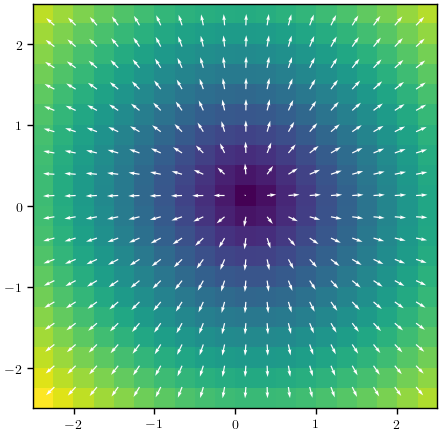

In [5]:
size = 20
x = np.linspace(-2.5, 2.5, size)
y = np.linspace(-2.5, 2.5, size)
xx, yy = np.meshgrid(x, y)

potential = lens.lens_model_class.potential(xx.flatten(), yy.flatten(), lens.kwargs_lens)

# Compute the gradient of the potential (deflection field)
potential_reshaped = potential.reshape((size, size))
grad_y, grad_x = np.gradient(potential_reshaped)

plt.imshow(potential_reshaped, extent=[-2.5, 2.5, -2.5, 2.5], cmap='viridis')
plt.quiver(xx, yy, grad_x, grad_y, color='white')
plt.show()

In [6]:
psf_kwargs = {'psf_type': 'NONE'}

Computing on pixel grid of size 365x365 (8.03"x8.03") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Building adaptive grid
Computing with 'adaptive' mode and supersampling factor 3
Adaptive grid: (365, 365)
Initialized SyntheticImage for StrongLens 00011398 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


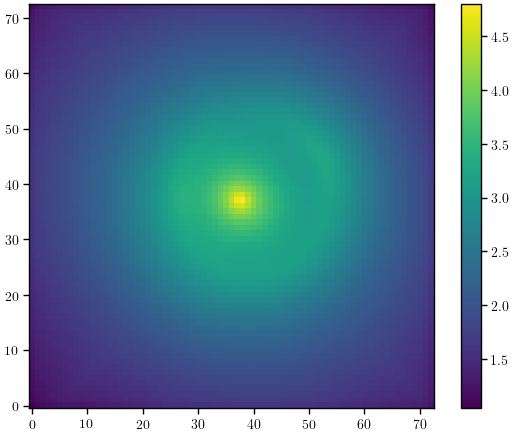

In [7]:
lens_without = deepcopy(lens)

synth_without = SyntheticImage(lens_without,
                                roman,
                                band=band,
                                arcsec=side,
                                oversample=grid_oversample,
                                instrument_params=instrument_params,
                                pieces=False,
                                verbose=True)

engine_params = {
    'detector_effects': False,
    'sky_background': False
}
exposure_without = Exposure(synth_without,
                                exposure_time=exposure_time,
                                engine_params=engine_params,
                                psf=psf,
                                verbose=True)

plt.imshow(np.log10(exposure_without.exposure))
plt.colorbar()
plt.show()

In [8]:
realization_6_8 = CDM(round(lens.z_lens, 2),
                   round(lens.z_source, 2),
                   log_mlow=6,
                   log_mhigh=8,
                   log_m_host=np.log10(lens.main_halo_mass),
                   cone_opening_angle_arcsec=5. * np.sqrt(2),
                   LOS_normalization=0.)

realization_8_9 = CDM(round(lens.z_lens, 2),
                   round(lens.z_source, 2),
                   log_mlow=8,
                   log_mhigh=9,
                   log_m_host=np.log10(lens.main_halo_mass),
                   cone_opening_angle_arcsec=5. * np.sqrt(2),
                   LOS_normalization=0.)

realization_9_10 = CDM(round(lens.z_lens, 2),
                   round(lens.z_source, 2),
                   log_mlow=9,
                   log_mhigh=10,
                   log_m_host=np.log10(lens.main_halo_mass),
                   cone_opening_angle_arcsec=5. * np.sqrt(2),
                   LOS_normalization=0.)

wdm = deepcopy(realization_9_10)
mdm = wdm.join(realization_8_9)
cdm = mdm.join(realization_6_8)

In [9]:
# fig = plt.figure(2)
# fig.set_size_inches(14,12)
# ax = plt.subplot(111, projection='3d')
# cdm.plot(ax)

In [10]:
# lens_model_list, lens_redshift_array, kwargs_halos, _ = cdm.lensing_quantities()
# # you can ignore the last argument for almost all use cases
# from lenstronomy.LensModel.lens_model import LensModel
# # You should use the same astropy class created in pyhalo to do lensing computations. The current default cosmology is Planck 2019
# astropy_instance = cdm.astropy_instance
# lens_model_halos_only = LensModel(lens_model_list, 
#                                   lens.z_lens, 
#                                   lens.z_source, 
#                                   lens_redshift_array, 
#                                   cosmo=astropy_instance, 
#                                   multi_plane=True)

# npix = 100 
# _x = _y = np.linspace(-1.2, 1.2, npix)
# xx, yy = np.meshgrid(_x, _y)
# shape0 = xx.shape
# kappa_subs = lens_model_halos_only.kappa(xx.ravel(), yy.ravel(), kwargs_halos).reshape(shape0)

# fig = plt.figure(1)
# fig.set_size_inches(8,8)
# plt.imshow(kappa_subs, cmap='bwr', norm=colors.CenteredNorm(), origin='lower')

In [11]:
lens_with = deepcopy(lens)

lens_with.add_subhalos(cdm, mass_sheet_correction=False)

synth_with = SyntheticImage(lens_with,
                            roman,
                            band=band,
                            arcsec=side,
                            oversample=grid_oversample,
                            instrument_params=instrument_params,
                            verbose=True)

exposure_with = Exposure(synth_with,
                    exposure_time=exposure_time,
                    engine_params=engine_params,
                    psf=psf,
                    verbose=True)

# plt.imshow(np.log10(exposure_with.exposure))
# plt.colorbar()
# plt.show()

Computing on pixel grid of size 365x365 (8.03"x8.03") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Building adaptive grid
Computing with 'adaptive' mode and supersampling factor 3
Adaptive grid: (365, 365)
Initialized SyntheticImage for StrongLens 00011398 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


In [12]:
# plt.imshow(synth_with.image - synth_without.image, norm=colors.CenteredNorm(), cmap='bwr')
# plt.colorbar()
# plt.show()

In [13]:
lens_wdm = deepcopy(lens)
lens_wdm.add_subhalos(wdm, mass_sheet_correction=False)
synth_wdm = SyntheticImage(lens_wdm,
                            roman,
                            band=band,
                            arcsec=side,
                            oversample=grid_oversample,
                            instrument_params=instrument_params,
                            verbose=True)
exposure_wdm = Exposure(synth_wdm,
                    exposure_time=exposure_time,
                    engine_params=engine_params,
                    psf=psf,
                    verbose=True)

lens_mdm = deepcopy(lens)
lens_mdm.add_subhalos(mdm, mass_sheet_correction=False)
synth_mdm = SyntheticImage(lens_mdm,
                            roman,
                            band=band,
                            arcsec=side,
                            oversample=grid_oversample,
                            instrument_params=instrument_params,
                            verbose=True)
exposure_mdm = Exposure(synth_mdm,
                    exposure_time=exposure_time,
                    engine_params=engine_params,
                    psf=psf,
                    verbose=True)

Computing on pixel grid of size 365x365 (8.03"x8.03") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Building adaptive grid
Computing with 'adaptive' mode and supersampling factor 3
Adaptive grid: (365, 365)
Initialized SyntheticImage for StrongLens 00011398 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00
Computing on pixel grid of size 365x365 (8.03"x8.03") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Building adaptive grid
Computing with 'adaptive' mode and supersampling factor 3
Adaptive grid: (365, 365)
Initialized SyntheticImage for StrongLens 00011398 by Roman in F129 band
Exposure calculation time with galsim engine: 0:00:00


In [14]:
f_cdm = cdm.masses.sum() / lens.main_halo_mass
print(f'CDM subhalo mass fraction: {f_cdm:.4f}')
f_mdm = mdm.masses.sum() / lens.main_halo_mass
print(f'MDM subhalo mass fraction: {f_mdm:.4f}')
f_wdm = wdm.masses.sum() / lens.main_halo_mass
print(f'WDM subhalo mass fraction: {f_wdm:.4f}')

CDM subhalo mass fraction: 0.0007
MDM subhalo mass fraction: 0.0002
WDM subhalo mass fraction: 0.0000


(0.00013256186733902618,
 array([<Axes: title={'center': '$\\sum_n \\int_{\\mathrm{annulus}}d^2\\theta\\,\\kappa_n=$0.020545'}>,
        <Axes: title={'center': '$\\int_{\\mathrm{annulus}}d^2\\theta\\,\\kappa_{\\mathrm{host}}=$154.981063'}>],
       dtype=object))

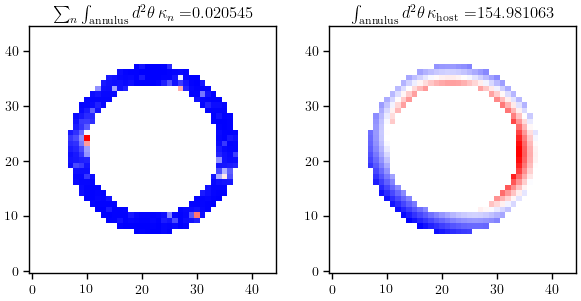

In [15]:
lens_with.get_f_sub(plot=True)

In [16]:
def autocorrelation(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

def plot_autocorrelation(x):
    return np.arange(len(x)), autocorrelation(x)

1. an image of a strong lens,
2. the image of the same strong lens with substructure,
3. residual of the two,
4. histogram of the pixel photon counts with and without subtructure,
5. 1D power spectrum with and without substructure overplotted,
6. Residual between the 2D power spectra (with and without substructure)?

In [17]:
wdm_image = exposure_wdm.exposure  # synth_wdm.image
mdm_image = exposure_mdm.exposure  # synth_mdm.image
cdm_image = exposure_with.exposure  # synth_with.image
smooth_image = exposure_without.exposure  # synth_without.image

In [18]:
ps1d_wdm, _ = correlation.power_spectrum_1d(wdm_image)
ps1d_mdm, _ = correlation.power_spectrum_1d(mdm_image)
ps1d_cdm, r = correlation.power_spectrum_1d(cdm_image)
ps1d_smooth, _ = correlation.power_spectrum_1d(smooth_image)

ps2d_cdm = correlation.power_spectrum_2d(cdm_image)
ps2d_smooth = correlation.power_spectrum_2d(smooth_image)

ps1d_residual, _ = correlation.power_spectrum_1d(cdm_image - smooth_image)
ps2d_residual = correlation.power_spectrum_2d(cdm_image - smooth_image)

ps1d_residual_wdm, _ = correlation.power_spectrum_1d(wdm_image - smooth_image)
ps1d_residual_mdm, _ = correlation.power_spectrum_1d(mdm_image - smooth_image)
ps1d_residual_cdm, _ = correlation.power_spectrum_1d(cdm_image - smooth_image)

# ps1d_with, r = correlation.power_spectrum_1d(exposure_with.exposure)
# ps1d_without, _ = correlation.power_spectrum_1d(exposure_without.exposure)
# ps1d_wdm, _ = correlation.power_spectrum_1d(exposure_wdm.exposure)
# ps1d_mdm, _ = correlation.power_spectrum_1d(exposure_mdm.exposure)

# ps2d_with = correlation.power_spectrum_2d(exposure_with.exposure)
# ps2d_without = correlation.power_spectrum_2d(exposure_without.exposure)

# ps1d_residual, _ = correlation.power_spectrum_1d(exposure_with.exposure - exposure_without.exposure)
# ps2d_residual = correlation.power_spectrum_2d(exposure_with.exposure - exposure_without.exposure)

# f, ax = plt.subplots(1, 4, figsize=(12, 4))
# ax[0].imshow(ps2d_with)
# ax[0].set_title('With Subhalos')

# ax[1].imshow(ps2d_without)
# ax[1].set_title('Without Subhalos')

# ax[2].imshow(np.log10(ps2d_with - ps2d_without), norm=colors.CenteredNorm(), cmap='bwr')

# ax[3].imshow(np.log10(ps2d_residual), norm=colors.CenteredNorm(), cmap='bwr')

# plt.show()

['9.99e+08', '8.11e+08', '6.23e+08', '3.46e+08', '2.40e+08', '1.86e+08', '1.85e+08', '1.54e+08', '1.12e+08', '1.11e+08']


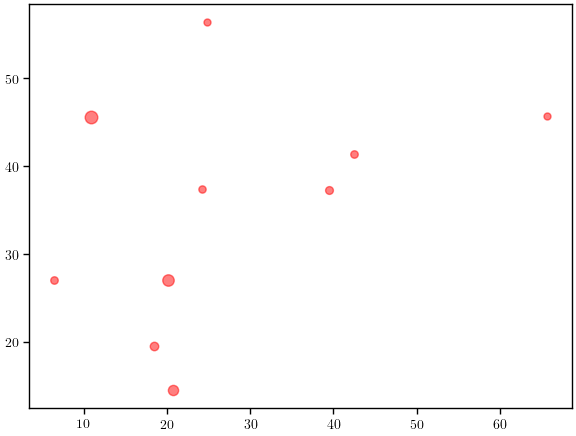

In [19]:
coords = lens_util.get_coords(num_pix)

cdm_subhalos = cdm.halos
cdm_subhalos_sorted = sorted(cdm_subhalos, key=lambda halo: halo.mass, reverse=True)
print([f'{h.mass:.2e}' for h in cdm_subhalos_sorted[:10]])

for halo in cdm_subhalos_sorted[:10]:
    x, y = coords.map_coord2pix(ra=halo.x, dec=halo.y)
    markersize = (halo.mass - 1e8) * (50 - 5) / (1e10 - 1e8) + 5
    plt.plot(x, y, 'o', markersize=markersize, alpha=0.5, color='red')
plt.show()

In [20]:
def plot_deflection_field(ax, lens, size=20, fov=5, cmap='viridis'):
    x = np.linspace(-fov / 2, fov / 2, size)
    y = np.linspace(-fov / 2, fov / 2, size)
    xx, yy = np.meshgrid(x, y)

    potential = lens.lens_model_class.potential(xx.flatten(), yy.flatten(), lens.kwargs_lens)

    # Compute the gradient of the potential (deflection field)
    potential_reshaped = potential.reshape((size, size))
    grad_y, grad_x = np.gradient(potential_reshaped)

    im = ax.imshow(potential_reshaped, extent=[-fov / 2, fov / 2, -fov / 2, fov / 2], cmap=cmap)
    ax.quiver(xx, yy, grad_x, grad_y, color='white')
    return im


def plot_residual_deflection_field(ax, lens_with, lens_without, size=20, fov=5, cmap='viridis', arrow_color='white'):
    x = np.linspace(-fov / 2, fov / 2, size)
    y = np.linspace(-fov / 2, fov / 2, size)
    xx, yy = np.meshgrid(x, y)

    potential_with = lens_with.lens_model_class.potential(xx.flatten(), yy.flatten(), lens_with.kwargs_lens)
    potential_without = lens_without.lens_model_class.potential(xx.flatten(), yy.flatten(), lens_without.kwargs_lens)
    potential_residual = potential_with - potential_without

    # Compute the gradient of the potential (deflection field)
    potential_reshaped = potential_residual.reshape((size, size))
    grad_y, grad_x = np.gradient(potential_reshaped)

    im = ax.imshow(potential_reshaped, extent=[-fov / 2, fov / 2, -fov / 2, fov / 2], cmap=cmap)
    ax.quiver(xx, yy, grad_x, grad_y, color=arrow_color)
    return im

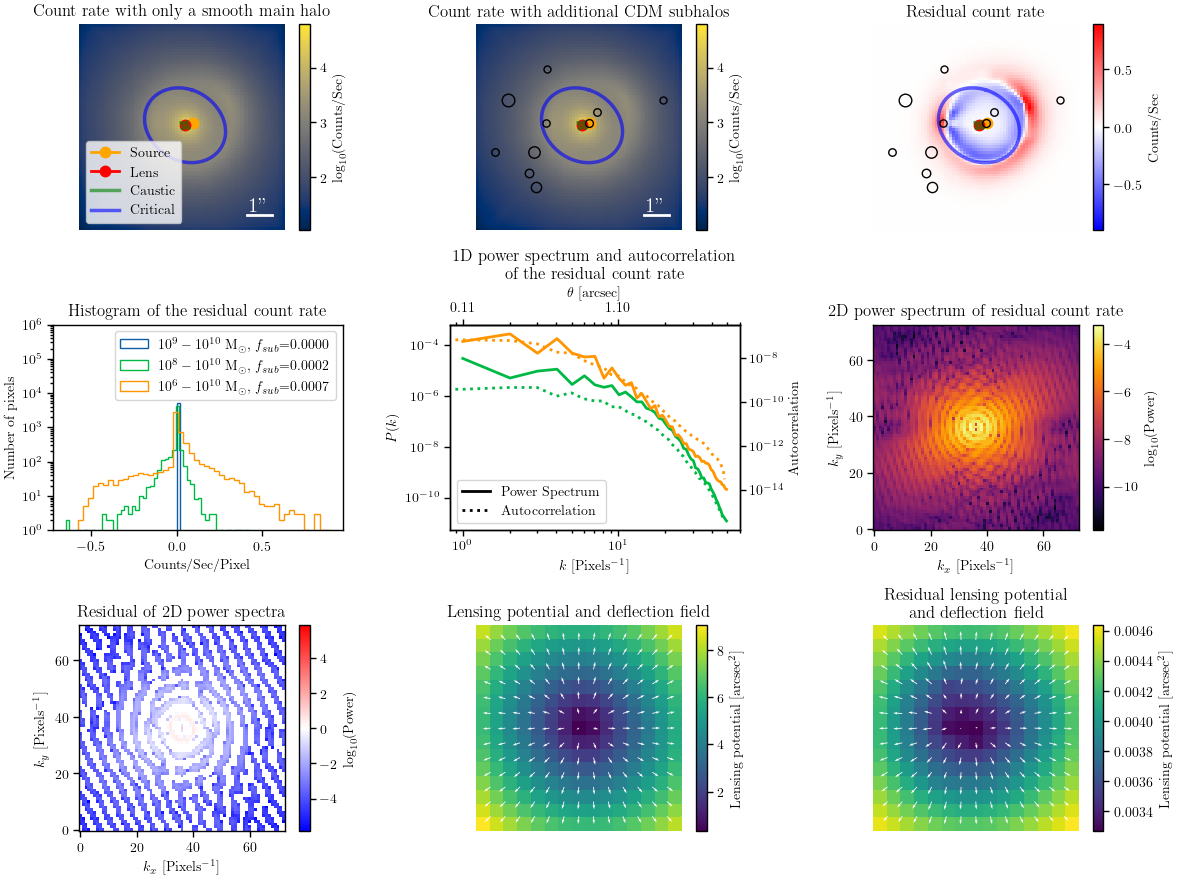

In [21]:
f, ax = plt.subplots(3, 3, figsize=(12, 9))  # , constrained_layout=True

num_subhalos = 10
coords = lens_util.get_coords(num_pix)
cdm_subhalos = cdm.halos
cdm_subhalos_sorted = sorted(cdm_subhalos, key=lambda halo: halo.mass, reverse=True)
# print([f'{h.mass:.2e}' for h in cdm_subhalos_sorted[num_subhalos]])

im = ax[0, 0].imshow(np.log10(smooth_image), cmap='cividis')
overplot.source_position(ax[0, 0], lens_without, coords, alpha=1, color='orange', size=7.5)
overplot.lens_position(ax[0, 0], lens_without, coords, alpha=1, color='red', size=7.5)
overplot.caustics(ax[0, 0], lens_without, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='g')
overplot.critical_curves(ax[0, 0], lens_without, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='b')
plot_util.scale_bar(ax[0, 0], d=smooth_image.shape[0], dist=1 / 0.11, text='1"', color='w', flipped=True)
ax[0, 0].legend()
ax[0, 0].set_title('Count rate with only a smooth main halo')
ax[0, 0].axis('off')
plt.colorbar(im, ax=ax[0, 0], label=r'$\log_{10}$(Counts/Sec)')

im = ax[0, 1].imshow(np.log10(cdm_image), cmap='cividis')
overplot.source_position(ax[0, 1], lens_with, coords, alpha=1, color='orange', size=7.5)
overplot.lens_position(ax[0, 1], lens_with, coords, alpha=1, color='red', size=7.5)
overplot.caustics(ax[0, 1], lens_with, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='g')
overplot.critical_curves(ax[0, 1], lens_with, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='b')
plot_util.scale_bar(ax[0, 1], d=smooth_image.shape[0], dist=1 / 0.11, text='1"', color='w', flipped=True)
for halo in cdm_subhalos_sorted[:num_subhalos]:
    x, y = coords.map_coord2pix(ra=halo.x, dec=halo.y)
    markersize = (halo.mass - 1e8) * (50 - 5) / (1e10 - 1e8) + 5
    ax[0, 1].plot(x, y, 'o', markersize=markersize, color='black', markerfacecolor='none')
ax[0, 1].set_title('Count rate with additional CDM subhalos')
ax[0, 1].axis('off')
plt.colorbar(im, ax=ax[0, 1], label=r'$\log_{10}$(Counts/Sec)')

im = ax[0, 2].imshow(cdm_image - smooth_image, norm=colors.CenteredNorm(), cmap='bwr')
overplot.source_position(ax[0, 2], lens_with, coords, alpha=1, color='orange', size=7.5)
overplot.lens_position(ax[0, 2], lens_with, coords, alpha=1, color='red', size=7.5)
overplot.caustics(ax[0, 2], lens_with, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='g')
overplot.critical_curves(ax[0, 2], lens_with, coords, num_pix, delta_pix=0.11, linewidth=2.5, alpha=0.6, color='b')
for halo in cdm_subhalos_sorted[:num_subhalos]:
    x, y = coords.map_coord2pix(ra=halo.x, dec=halo.y)
    markersize = (halo.mass - 1e8) * (50 - 5) / (1e10 - 1e8) + 5
    ax[0, 2].plot(x, y, 'o', markersize=markersize, color='black', markerfacecolor='none')
ax[0, 2].set_title('Residual count rate')
ax[0, 2].axis('off')
plt.colorbar(im, ax=ax[0, 2], label='Counts/Sec')

bins = 50 # int(np.sqrt(synth_without.image.shape[0] * synth_without.image.shape[1]))
ax[1, 0].hist((wdm_image - smooth_image).flatten(), bins=bins, histtype='step', label=r'$10^9-10^{10}$ M$_\odot$, $f_{sub}$=' + f'{f_wdm:.4f}')
ax[1, 0].hist((mdm_image - smooth_image).flatten(), bins=bins, histtype='step', label=r'$10^8-10^{10}$ M$_\odot$, $f_{sub}$=' + f'{f_mdm:.4f}')
ax[1, 0].hist((cdm_image - smooth_image).flatten(), bins=bins, histtype='step', label=r'$10^6-10^{10}$ M$_\odot$, $f_{sub}$=' + f'{f_cdm:.4f}')
ax[1, 0].set_title('Histogram of the residual count rate')
ax[1, 0].set_xlabel('Counts/Sec/Pixel')
ax[1, 0].set_ylabel('Number of pixels')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim(1, 1e6)
ax[1, 0].legend()

ax[1, 1].plot(r, ps1d_residual_wdm)
ax[1, 1].plot(r, ps1d_residual_mdm)
ax[1, 1].plot(r, ps1d_residual_cdm)
ax[1, 1].set_title('1D power spectrum and autocorrelation\nof the residual count rate')
ax[1, 1].set_xlabel(r'$k$ [Pixels$^{-1}$]')
ax[1, 1].set_ylabel(r'$P(k)$')
ax[1, 1].set_xscale('log')
ax[1, 1].set_yscale('log')
solid_line = Line2D([0], [0], color='black', linestyle='-', label='Solid Line')
dotted_line = Line2D([0], [0], color='black', linestyle=':', label='Dotted Line')
ax[1, 1].legend([solid_line, dotted_line], ['Power Spectrum', 'Autocorrelation'])

twinxy = ax[1, 1].twinx()
secax = ax[1, 1].secondary_xaxis('top')
secax.set_xlabel(r'$\theta$ [arcsec]')
secax.set_xticks(ax[1, 1].get_xticks())
secax.set_xticklabels([f'{0.11 * tick:.2f}' for tick in ax[1, 1].get_xticks()])
twinxy.set_xscale('log')
twinxy.set_yscale('log')
twinxy.set_ylabel('Autocorrelation')
twinxy.plot(*plot_autocorrelation(ps1d_residual_wdm), color='C0', linestyle=':')
twinxy.plot(*plot_autocorrelation(ps1d_residual_mdm), color='C1', linestyle=':')
twinxy.plot(*plot_autocorrelation(ps1d_residual_cdm), color='C2', linestyle=':')

im = ax[1, 2].imshow(np.log10(ps2d_residual), cmap='inferno')
ax[1, 2].set_title('2D power spectrum of residual count rate')
ax[1, 2].set_xlabel(r'$k_x$ [Pixels$^{-1}$]')
ax[1, 2].set_ylabel(r'$k_y$ [Pixels$^{-1}$]')
ax[1, 2].set_aspect('equal')
plt.colorbar(im, ax=ax[1, 2], label=r'$\log_{10}$(Power)')

im = ax[2, 0].imshow(np.log10(ps2d_cdm - ps2d_smooth), cmap='bwr', norm=colors.CenteredNorm())
ax[2, 0].set_title('Residual of 2D power spectra')
ax[2, 0].set_xlabel(r'$k_x$ [Pixels$^{-1}$]')
ax[2, 0].set_ylabel(r'$k_y$ [Pixels$^{-1}$]')
ax[2, 0].set_aspect('equal')
plt.colorbar(im, ax=ax[2, 0], label=r'$\log_{10}$(Power)')

im = plot_deflection_field(ax[2, 1], lens_with, size=15, fov=side, cmap='viridis')
ax[2, 1].set_title('Lensing potential and deflection field')
ax[2, 1].axis('off')
plt.colorbar(im, ax=ax[2, 1], label=r'Lensing potential [arcsec$^2$]')

im = plot_residual_deflection_field(ax[2, 2], lens_with, lens_without, size=15, fov=side, cmap='viridis', arrow_color='white')
ax[2, 2].set_title('Residual lensing potential\nand deflection field')
ax[2, 2].axis('off')
plt.colorbar(im, ax=ax[2, 2], label=r'Lensing potential [arcsec$^2$]')

# plt.suptitle(r'$z_{lens}$=' + f'{lens.z_lens:.2f}, ' + r'$z_{source}$=' + f'{lens.z_source:.2f}, {exposure_time} s exposure with {band} filter on SCA{str(sca).zfill(2)}, 5x5 arcsec cutouts')
plt.tight_layout()
# plt.subplots_adjust(wspace=0.05)
plt.savefig('example.png')
plt.show()